# Работа с небольшими корпусами. Первичные наблюдения

В этом ноутбуке рассматривались корпуса небольшого размера, а также производилась работа без выравнивания. В дальнейшем такой подход не нашел применения, и было решено заняться как увеличением корпуса вместе и его пословным выравниванием

## Dependencies:

Turning on venv for ipynb

In [7]:
# ! python -m venv .venv
# ! source ./.venv/bin/activate
# ! pip install ipykernel
# ! ipython kernel install --user --name=translational_variability

Package installation

In [8]:
# ! pip install spacy
# ! python -m spacy download en_core_web_lg
# ! python -m spacy download en_core_web_trf
# ! python -m spacy download ru_core_news_lg
# ! pip install matplotlib
# ! pip install numpy

In [9]:
import os
import spacy
from collections import Counter, defaultdict
from pprint import pprint

from matplotlib import pyplot as plt
import numpy as np

### Открываем файлы

In [10]:
with open("./text/ru.txt", "rt", encoding="utf-8") as file:
    ru_corpus_raw = [line.rstrip() for line in file]

ru_corpus_raw[:2]

['Однажды весною, в час небывало жаркого заката, в Москве, на Патриарших прудах, появились два гражданина.',
 'Первый из них, одетый в летнюю серенькую пару, был маленького роста, упитан, лыс, свою приличную шляпу пирожком нес в руке, а на хорошо выбритом лице его помещались сверхъестественных размеров очки в черной роговой оправе.']

In [11]:
with open("./text/en.txt", "rt", encoding="utf-8") as file:
    en_corpus_raw = [line.rstrip() for line in file]

en_corpus_raw[:2]

["At the hour of the hot spring sunset two citizens appeared at the Patriarch's Ponds.",
 'One of them, approximately forty years old, dressed in a grey summer suit, was short, dark-haired, plump, bald, and carried his respectable fedora hat in his hand. His neatly shaven face was adorned with black horn-rimmed glasses of a supernatural size.']

### Cамые частотные слова -- выбираем кандидатов для анализа

In [12]:
def most_common_lemmas(doc, n: int):
    words = [token.lemma_.lower()
            for token in doc
            if not token.is_stop and not token.is_punct]
    word_freq = Counter(words)
    return word_freq.most_common(n)
    

In [13]:
en_nlp_lg = spacy.load("en_core_web_lg")
ru_nlp_lg = spacy.load("ru_core_news_lg")

In [14]:
en_all_doc = en_nlp_lg(" ".join(en_corpus_raw))

In [15]:
most_common_lemmas(en_all_doc, 20)

[('margarita', 612),
 ('say', 556),
 ('come', 492),
 ('`', 481),
 ('man', 465),
 ('go', 397),
 ('eye', 376),
 ('ivan', 360),
 ('begin', 333),
 ('know', 328),
 ('ask', 318),
 ('hand', 309),
 ('head', 292),
 ('time', 285),
 ('look', 276),
 ('turn', 273),
 ('procurator', 268),
 ('woland', 266),
 ('reply', 254),
 ('cat', 245)]

In [16]:
ru_all_doc = ru_nlp_lg(" ".join(ru_corpus_raw))

In [17]:
most_common_lemmas(ru_all_doc, 20)

[('маргарита', 554),
 ('сказать', 469),
 ('иван', 352),
 ('рука', 350),
 ('человек', 349),
 ('глаз', 346),
 ('ответить', 293),
 ('говорить', 265),
 ('прокуратор', 265),
 ('воланд', 260),
 ('знать', 253),
 ('ни', 246),
 ('голова', 242),
 ('лицо', 228),
 ('коровьев', 226),
 ('спросить', 221),
 ('кот', 221),
 ('время', 213),
 ('пилат', 192),
 ('голос', 184)]

С первого же взгляда на топ слов видно, что он не совпадает. Например, слово man в английской версии встретилось 465 раз, а слова "мужчина" или "человек" с такой же частотностью у нас нет. Человек встречается в топе русского текста, но встретился он всего 349 раз

В топе много имен, рассматривать их перевод смысла нет, потому что вероятность, что слово "Маргарита" переведут как "John" довольно мала

Следует выбрать какое-то абстрактное слово, какое-то конкретное слово, и какое-то отглагольное прилагательное
Начнем с конкретного существительного, например с "человека", так как он в том или ином виде встречается сразу в двух топах, и кажется немногозначным

### Вспомогательные функции для частотника по частям речи, построения словаря и рисования графиков

In [18]:
def most_common_pos(doc, pos: str, n: int):
    pos_words = [token.lemma_.lower()
         for token in doc
         if (not token.is_stop and
             not token.is_punct and
             token.pos_ == pos)]
    pos_words_freq = Counter(pos_words)
    common_pos_words = pos_words_freq.most_common(n)
    return(common_pos_words)

In [19]:
en_nlp_trf = spacy.load("en_core_web_trf")

In [20]:
def get_variety_dict_and_unclear_sentences_numbers(original_word: str, suggested_translations: set):
    """
    Строит словарь совпадений исходного слова и его переводов.
    В случае, если предполагаемых переводов <= 5,
    лучше передавать list вместо set
    """
    variety_dict = defaultdict(lambda : 0)
    unclear_sentences_numbers = []

    for line_number in range(0, len(ru_corpus_raw)):
        ru_line = ru_corpus_raw[line_number]
        ru_line_doc = ru_nlp_lg(ru_line)
        
        original_language_matches = 0
        for token in ru_line_doc:
            if token.lemma_.lower() == original_word:
                original_language_matches += 1
        if original_language_matches == 0:
            continue

        en_line = en_corpus_raw[line_number]
        en_line_doc = en_nlp_trf(en_line)

        number_of_matches = 0
        tmp_dict = defaultdict(lambda : 0)
        for token in en_line_doc:
            if token.lemma_.lower() in suggested_translations:
                number_of_matches += 1
                tmp_dict[token.lemma_.lower()] += 1
        if number_of_matches != original_language_matches:
            unclear_sentences_numbers.append(line_number)
            continue
        for key, val in tmp_dict.items():
            variety_dict[key] += val
    
    return (variety_dict, unclear_sentences_numbers)

In [21]:
def plot_variety_pie(variety_dict, other_len: int, original_word: str):
    variety_dict_items = list(variety_dict.items())
    translations = [x[0] for x in variety_dict_items]
    translations.append("other")
    number_of_matches = [x[1] for x in variety_dict_items]
    number_of_matches.append(other_len)

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)
        
    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend()

    # show plot
    plt.show()

In [22]:
def print_unclear_sentences_from_numbers(unclear_sentences_numbers):
    for number in unclear_sentences_numbers:
        print(ru_corpus_raw[number])
        print(en_corpus_raw[number])
        print()

## Существительные

In [23]:
most_common_pos(ru_all_doc, "NOUN", 20)

[('рука', 350),
 ('человек', 349),
 ('глаз', 346),
 ('прокуратор', 264),
 ('голова', 242),
 ('лицо', 228),
 ('кот', 221),
 ('время', 213),
 ('голос', 184),
 ('слово', 175),
 ('дело', 166),
 ('мастер', 161),
 ('гость', 155),
 ('квартира', 151),
 ('дверь', 142),
 ('нога', 127),
 ('женщина', 123),
 ('город', 117),
 ('окно', 116),
 ('комната', 114)]

### Человек

ru -> en
первое совпадение
в русском используется лучшая модель с суффиксом lg, в английском доступна с trf

In [24]:
original_word = "человек"
suggested_translations = set(["human", "person", "man", "woman", "people", "someone", "anyone", "somebody", "anybody", "fellow"])
variety_dict, unclear_sentences_numbers = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

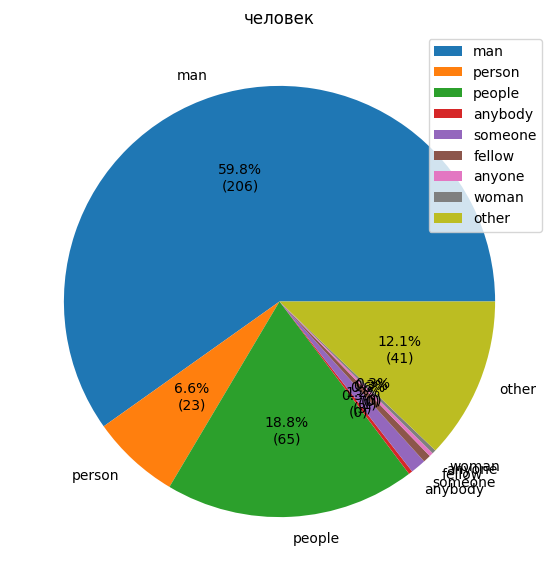

In [25]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers), original_word)

* Иногда слова вроде man терялись из-за другого построения предложения. Это специфика языка, так что такие предложения будут в дальнейшем исключены из рассмотрения 

    *некоего Дисмаса* - *such men as a certain Dysmas*

    Или другой пример, где слово с начальной формой "человек" встретилось в русском один раз, а в английском два, и причем по-разному

    *– Беда в том, – продолжал никем не останавливаемый связанный, – что ты слишком замкнут и окончательно потерял веру в людей.*
    
    *'The trouble is,' the bound man went on, not stopped by anyone, 'that you are too closed off and have definitively lost faith in people.*

* Предложения тоже могли не соответствовать друг другу из-за проблем корпуса (таких случаев очень мало, они не должны влиять на статистику)

    *У этой двери также была очередь, но не чрезмерная, человек в полтораста.*

    *Next, obedient to the whimsical curves, ascents and descents of the Griboedov house, came the `Massolit Executive Board', 'Cashiers nos.*

* Были ложные срабатывания, например слово "человек" опустили из-за грамматики, но где-то рядом в тексте была "woman"

* Пословицы и поговорки!

    *Все люди как люди, ходят сейчас по улицам, наслаждаются весенним солнцем и теплом, а вы здесь на полу торчите в душном зале!*

    *Everybody else is out walking around now, enjoying the spring sun and the warmth, and you're stuck in here on the floor of a stuffy theatre!*

* И, самое интересное, другие переводы (которые далее были включены в список)

    *Будучи по природе вообще подозрительным человеком, он заключил, что разглагольствующий перед ним гражданин – лицо именно неофициальное, а пожалуй, и праздное.*

    *Being a generally suspicious person by nature, he concluded that the man holding forth in front of him was precisely an unofficial person, and perhaps even an idle one.*

В итоге по поводу слова "человек" я ошибалась, потому что оно часто может опускаться из-за несовпадений граматических конструкций (идущий -- the man who walked, например). По ощущениям есть шанс, что в других языках ситуация может быть ещё менее приятной

### Рука

In [26]:
original_word = "рука"
suggested_translations = set(["arm", "hand"])
variety_dict, unclear_sentences_numbers = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

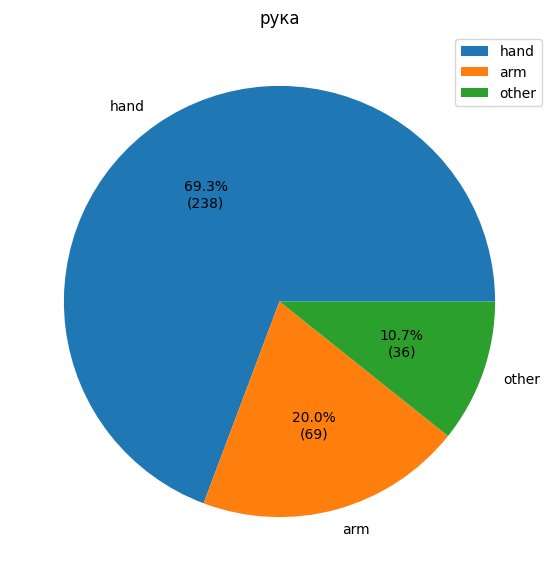

In [27]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers), original_word)

### Время

In [28]:
original_word = "время"
suggested_translations = set(["time", "moment", "hour", "meanwhile", "lately", "during"])
variety_dict, unclear_sentences_numbers = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

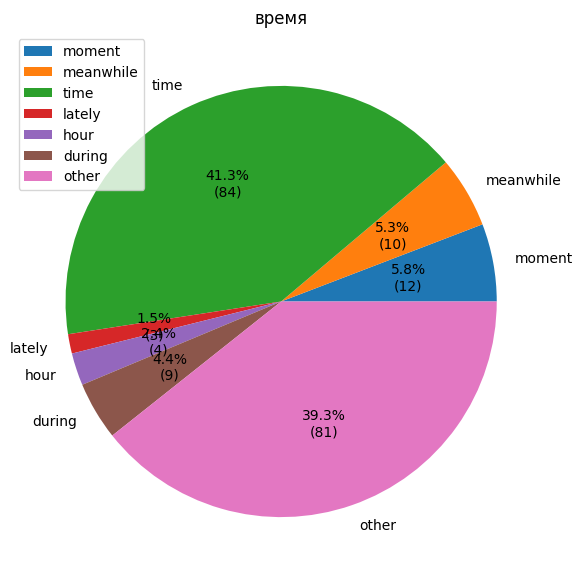

In [29]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers), original_word)

Плохое слово получилось. Слишком много оборотов, которые в русском образуются со словом "время", а в английском имеют отдельное слово (в то время как -- during и так далее)

In [30]:
print_unclear_sentences_from_numbers(unclear_sentences_numbers)

Берлиоз говорил, а сам в это время думал: «Но, все-таки, кто же он такой?
Berlioz spoke, thinking all the while: 'But, anyhow, who is he?

Я советовал бы тебе, игемон, оставить на время дворец и погулять пешком где-нибудь в окрестностях, ну хотя бы в садах на Елеонской горе.
I'd advise you, Hegemon, to leave the palace for a while and go for a stroll somewhere in the vicinity - say, in the gardens on the Mount of Olives.

Но, выйдя из-под колоннады на заливаемую солнцем верхнюю площадь сада с пальмами на чудовищных слоновых ногах, площадь, с которой перед прокуратором развернулся весь ненавистный ему Ершалаим с висячими мостами, крепостями и – самое главное – с не поддающейся никакому описанию глыбой мрамора с золотою драконовой чешуею вместо крыши – храмом Ершалаимским, – острым слухом уловил прокуратор далеко и внизу, там, где каменная стена отделяла нижние террасы дворцового сада от городской площади, низкое ворчание, над которым взмывали по временам слабенькие, тонкие не то стоны, 

## Глаголы

In [31]:
most_common_pos(ru_all_doc, "VERB", 15)

[('сказать', 469),
 ('ответить', 293),
 ('говорить', 265),
 ('знать', 253),
 ('спросить', 221),
 ('видеть', 174),
 ('сидеть', 153),
 ('увидеть', 127),
 ('сделать', 112),
 ('прийти', 101),
 ('идти', 98),
 ('оказаться', 96),
 ('заговорить', 95),
 ('начать', 90),
 ('глядеть', 82)]

### Сказать

In [32]:
original_word = "сказать"
suggested_translations = set(["say", "tell", "speak", "mention"])
variety_dict, unclear_sentences_numbers = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

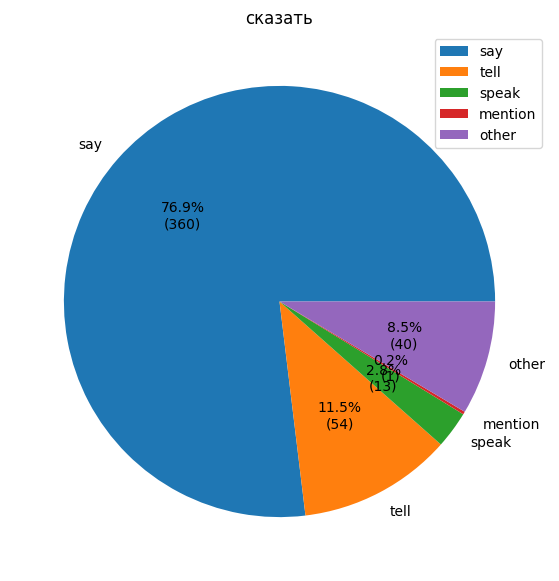

In [33]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers), "сказать")

### Говорить

In [34]:
original_word = "говорить"
suggested_translations = set(["say", "tell", "speak", "mention"])
variety_dict, unclear_sentences_numbers_1 = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

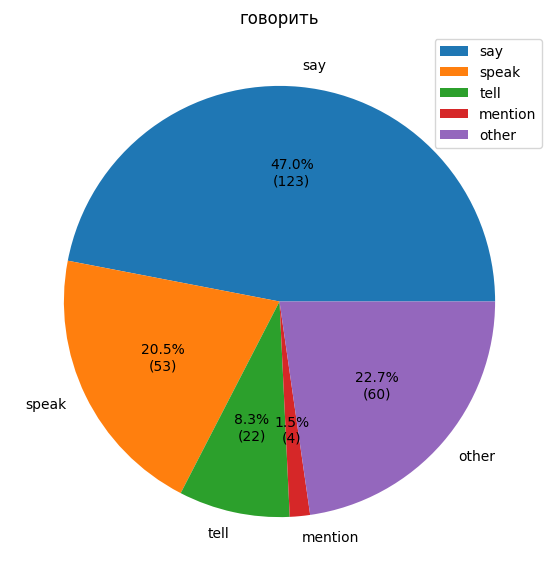

In [35]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers_1), "говорить")

## Прилагательные

In [ ]:
most_common_pos(ru_all_doc, "ADJ", 15)

[('чёрный', 175),
 ('первый', 133),
 ('белый', 109),
 ('второй', 87),
 ('неизвестный', 80),
 ('римский', 80),
 ('последний', 70),
 ('полный', 68),
 ('передний', 61),
 ('маленький', 58),
 ('тёмный', 57),
 ('золотой', 54),
 ('страшный', 53),
 ('хороший', 52),
 ('странный', 51)]

In [ ]:
pos_words = set([token.pos_ for token in ru_all_doc])
pos_words

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'VERB',
 'X'}

In [37]:
original_word = "полный"
suggested_translations = set(["full", "thick", "entire", "whole", "complete", "utter", "total", "absolute", "plump", "perfect"])
variety_dict, unclear_sentences_numbers_2 = get_variety_dict_and_unclear_sentences_numbers(original_word, suggested_translations)

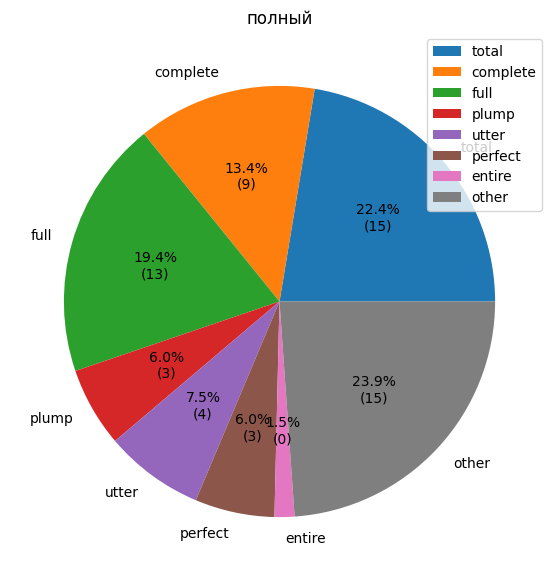

In [38]:
plot_variety_pie(variety_dict, len(unclear_sentences_numbers_2), "полный")

In [ ]:
print_unclear_sentences_from_numbers(unclear_sentences_numbers)

В квартире стояла полнейшая тишина.
The apartment was perfectly silent.

В полном смятении он рысцой побежал в спальню и застыл на пороге. Волосы его шевельнулись, и на лбу появилась россыпь мелкого пота.
Utterly bewildered, he trotted back to the bedroom and froze on the threshold. His hair stood on end and small beads of sweat broke out on his brow.

Цилиндр тихо прозвенел в ответ, остановился, потух, и в комнату вошла полная симпатичная женщина в белом чистом халате и сказала Ивану:
The cylinder rang quietly in response, stopped, the light went out, and a plump, sympathetic woman in a clean white coat came into the room and said to Ivan:

А вашему товариществу, Никанор Иванович, полнейшая выгода и очевидный профит.
And for your association, Nikanor Ivanovich, it's a sheer gain and an obvious profit.

Вскоре заречный бор стал прежним. Он вырисовался до последнего дерева под небом, рассчистившимся до прежней полной голубизны, а река успокоилась.
Soon the woods across the river became 